In [ ]:
import numpy as np
from scipy.integrate import trapz as scipy_trapz
import pandas as pd
import matplotlib.pyplot as plt

class Node:
    '''This class takes care of the backward AD. All intermediate values should be an instance of the Node class to ensure a proper graph structure forms in the forward pass.
    The backward method below is the actual backward pass and calculates/accumulates all the gradients by going up the graph, starting from the outputs'''
    def __init__(self, value, parents=None, grad_fn=None):
        self.value = value
        self.grad = 0.0
        self.parents = parents if parents is not None else []
        self.grad_fn = grad_fn
        
    def backward(self, upstream_grad=1.0):
        self.grad += upstream_grad
        if self.grad_fn is not None:
            local_grads = self.grad_fn(upstream_grad)
            for parent, local_grad in zip(self.parents, local_grads):
                parent.backward(local_grad)
'''The functions below are custom made to help with the gradient calculations'''
def add(x, y):
    value = x.value + y.value
    def grad_fn(upstream_grad):
        return [upstream_grad, upstream_grad]
    return Node(value, parents=[x, y], grad_fn=grad_fn)

def subtract(x, y):
    value = x.value - y.value
    def grad_fn(upstream_grad):
        return [upstream_grad, -upstream_grad]
    return Node(value, parents=[x, y], grad_fn=grad_fn)

def multiply(x, y):
    value = x.value * y.value
    def grad_fn(upstream_grad):
        return [upstream_grad * y.value, upstream_grad * x.value]
    return Node(value, parents=[x, y], grad_fn=grad_fn)

def exp(x):
    value = np.exp(x.value)
    def grad_fn(upstream_grad):
        return [upstream_grad * value]
    return Node(value, parents=[x], grad_fn=grad_fn)

def maximum(x, y):
    value = max(x.value, y.value)
    def grad_fn(upstream_grad):
        grad_x = upstream_grad if x.value > y.value else 0.0
        grad_y = upstream_grad if y.value >= x.value else 0.0
        return [grad_x, grad_y]
    return Node(value, parents=[x, y], grad_fn=grad_fn)

def divide(x, y):
    value = x.value / y.value
    def grad_fn(upstream_grad):
        return [upstream_grad / y.value, -upstream_grad * x.value / (y.value ** 2)]
    return Node(value, parents=[x, y], grad_fn=grad_fn)

def trapz(y, x):
    values = np.array([node.value for node in y])
    value = scipy_trapz(values, [node.value for node in x])
    def grad_fn(upstream_grad):
        d = np.diff([node.value for node in x])
        grad_y = np.zeros_like(values)
        grad_y[0] += upstream_grad * d[0] / 2
        grad_y[-1] += upstream_grad * d[-1] / 2
        for i in range(1, len(values) - 1):
            grad_y[i] += upstream_grad * (d[i-1] + d[i]) / 2
        return [Node(grad) for grad in grad_y]
    return Node(value, parents=y, grad_fn=grad_fn)

def power(x, p):
    value = x.value ** p
    def grad_fn(upstream_grad):
        return [upstream_grad * p * (x.value ** (p - 1))]
    return Node(value, parents=[x], grad_fn=grad_fn)

def sqrt(x):
    value = np.sqrt(x.value)
    def grad_fn(upstream_grad):
        return [upstream_grad/(2 * np.sqrt(x.value)) ]
    return Node(value, parents=[x], grad_fn=grad_fn)
def linspace(start, stop, num):
    step = (stop.value - start) / (num - 1)
    return [add(Node(start), multiply(Node(i), Node(step))) for i in range(num)]



In [2]:
'''This is the function to simulate the interest rate curves according to the hull-white 1 factor model. We have tried to ensure all operations are done so that the nodes are created at every stage to ensure proper graph formation'''
def simulate_Hull_White_One_Factor(r0, a, sigma, f, t):
    N = len(t)
    r = [r0]
    sigma_node = Node(sigma)
    a_node = Node(a)
    f_nodes = [Node(f_i) for f_i in f]
    t_nodes = t#[Node(t_i) for t_i in t]

    alpha = [
        add(
            f_nodes[i],
            multiply(
                divide(power(sigma_node, 2), multiply(Node(2), power(a_node, 2))),
                power(subtract(Node(1), exp(multiply(Node(-a), t_nodes[i]))), 2)
            )
        ) for i in range(N)
    ]

    for el in range(1, N):
        deltat = subtract(t_nodes[el], t_nodes[el - 1])
        exp_neg_a_deltat = exp(multiply(Node(-a), deltat))
        e = multiply(r[el - 1], exp_neg_a_deltat)
        alpha_diff = subtract(alpha[el], multiply(alpha[el - 1], exp_neg_a_deltat))
        e = add(e, alpha_diff)
        v = multiply(
            divide(power(sigma_node, 2), multiply(Node(2), a_node)),
            subtract(Node(1), exp(multiply(multiply(Node(-2),a_node), deltat)))
        )
        r.append(Node(np.random.normal(e.value, np.sqrt(v.value))))
    return r


'''This is just a helper function'''
def simulateIR(start_time, T, N, rd, rf, forwards, a, sigma, t):
    f = forwards
    rd_sim = simulate_Hull_White_One_Factor(rd, a, sigma, f, t)
    rf_sim = simulate_Hull_White_One_Factor(rf, a, sigma, f, t)
    return [subtract(rd_sim[i], rf_sim[i]) for i in range(N)]


In [3]:
'''We will use the Garman-Kohlhagen model for FX options. It is same as Black_Scholes but the interest rate is replaced by r_domestic - r_foreign
    #More details here:https://en.wikipedia.org/wiki/Foreign_exchange_option#:~:text=In%20finance%2C%20a%20foreign%20exchange,rate%20on%20a%20specified%20date. Again all operations have been changed to the corresponding node operations to ensure proper flow in the backward pass.'''
def bs_price(S, K, T, r, vol):
    """Calculates the price of a European call option using the Black-Scholes model."""
    d1 = (np.log(S / K) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)
    price =  (S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))
    return price


def MonteCarloPricer(params, N, M, a, sigma,stock_vol):
    S0, K, start_time, T, H, rd, rf, vol, mu = params[:9]
    forwards = params[9:]
    t = linspace(start_time, T, N)
    dt = divide(subtract(T, Node(start_time)), Node(N))
    dt_stock = (T.value - start_time)/N
    nudt = multiply(subtract(mu, multiply(Node(0.5), multiply(vol, vol))), dt)
    volsdt = multiply(vol, sqrt(dt))
    sum_CT = Node(0.0)
    stockT = 0
    CT_array = np.zeros(M) # Create an array to store CT values

    for i in range(M):
        BARRIER = False
        St,stockt = S0,S0


        for j in range(N):
            increments = np.random.multinormal([0,0],[[1, corr],[corr, 1]])
            epsilon = Node(increments[0])
            Stn = multiply(St, exp(add(nudt, multiply(volsdt, epsilon))))
            stock_end = stockt*exp((rd - 0.5 * stock_vol ** 2)*dt_stock+ stock_vol*np.sqrt(dt_stock)*increments[1])
            St = Stn
            if St.value >= H.value:
                BARRIER = True
                break

        if BARRIER:
            CT = Node(0.0)
        else:
            CT = maximum(Node(0.0), subtract(St, K))

        SimulatedRates = simulateIR(start_time, T, N, rd, rf, forwards, a, sigma, t)
        discountfactor = trapz(SimulatedRates, t)
        CT = multiply(CT, Node(np.exp(-discountfactor.value)))
        CT_array[i] = CT.value #store each CT
        sum_CT = add(sum_CT, CT)
        stockT += stock_end

    C0 = divide(sum_CT, Node(M))

    C0.backward()

    gradients = {
        'dC0_dS0': round(S0.grad,2),
        'dC0_dK': round(K.grad,2),
        'dC0_drd': round(rd.grad,2),
        'dC0_drf': round(rf.grad,2),
        'dC0_dvol': round(vol.grad,2),
        'dC0_dT': round(T.grad,2),
        'dC0_dmu':round(mu.grad,2)
    }

    return C0.value, gradients, CT_array,stockT

In [4]:
'''Please set T to the value for end_time - start_time and always keep start_time to be 0. Computationally it does not matter anyways. It makes for an easier implementation'''
N = 100       # number of time steps
M = 1000      # number of simulations
#t = np.linspace(0, 1, N)
params = [Node(100), Node(100), 0, Node(1), Node(125), Node(0.02), Node(0.02), Node(0.2), Node(0.01)]#S0,K,start_time,T,H,rd,rf,vol,mu
forwards = list(np.linspace(params[2], params[3].value, N) * 0.03)# If specifying manually please ensure that N is set to the size of forwards, so that integration and simulation takes place at only these times
params = params + forwards
a = 0.04#Interest rate evolution parameters
sigma = 0.2#Interest rate evolution parameters
stock_vol = 0.3
OptionPrice, gradients,_,stock_final = MonteCarloPricer(params, N, M, a, sigma,stock_vol)
print("Call value is ${0} in domestic currency ".format(np.round(OptionPrice, 2)))
print("Gradients:", gradients)

Call value is $2.51 in domestic currency 
Gradients: {'dC0_dS0': 0.31, 'dC0_dK': -0.28, 'dC0_drd': 0.0, 'dC0_drf': 0.0, 'dC0_dvol': 8.75, 'dC0_dT': 1.18, 'dC0_dmu': 30.7}


In [5]:
def compute_risk_metrics(params, N, M, a, sigma):
    recovery_rate = 0.4 #Adjustable
    T = params[3]  #Storing the original Time to Maturity # see the above code for params' specification
    params[3] = add(params[3],(divide(T,Node(12)))) # Just to make the for loop such that the first run is T instead of 11/12 T 
    
    Expected_Exposure = pd.DataFrame(columns=['default_time', 'Exposure'])
    Potential_Exposure = pd.DataFrame(columns=['default_time', 'Exposure'])
    
    for i in range (12):
        params[3] = subtract(params[3],(divide(T,Node(12)))) #calculate every after 1/12 portion of maturity time
        _, _, CT_array = MonteCarloPricer(params, N, M, a, sigma)

        #By definition, EE and PE does not depend on default rate
        expected_exposure = np.mean(CT_array) * recovery_rate # Option price never negative
        potential_exposure = np.quantile(CT_array, 0.95) * recovery_rate #95% quantile
        
        Expected_Exposure.loc[i] = [subtract(T, params[3]).value, expected_exposure]
        Potential_Exposure.loc[i] = [subtract(T, params[3]).value, potential_exposure]
        
    return Expected_Exposure, Potential_Exposure

In [6]:
N = 100       # number of time steps
M = 1000      # number of simulations
#t = np.linspace(0, 1, N)
params = [Node(100), Node(100), 0, Node(1), Node(125), Node(0.02), Node(0.02), Node(0.2), Node(0.01)] #S0,K,start_time,T,H,rd,rf,vol,mu
forwards = list(np.linspace(params[2], params[3].value, N) * 0.03) # If specifying manually please ensure that N is set to the size of forwards, so that integration and simulation takes place at only these times
params = params + forwards
a = 0.04 #Interest rate evolution parameters
sigma = 0.2 #Interest rate evolution parameters

Expected_Exposure, Potential_Exposure = compute_risk_metrics(params, N, M, a, sigma)

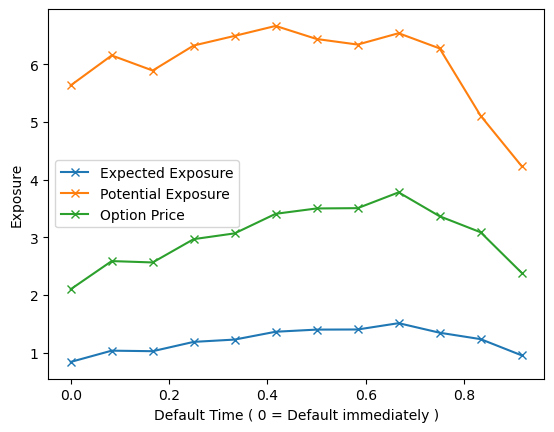

------------------------------------------------------
Expected Exposure
    default_time  Exposure
0         0.0000    0.8401
1         0.0833    1.0354
2         0.1667    1.0260
3         0.2500    1.1877
4         0.3333    1.2277
5         0.4167    1.3634
6         0.5000    1.4005
7         0.5833    1.4026
8         0.6667    1.5121
9         0.7500    1.3465
10        0.8333    1.2353
11        0.9167    0.9545
Potential Exposure
    default_time  Exposure
0         0.0000    5.6349
1         0.0833    6.1546
2         0.1667    5.8927
3         0.2500    6.3264
4         0.3333    6.4934
5         0.4167    6.6662
6         0.5000    6.4394
7         0.5833    6.3429
8         0.6667    6.5399
9         0.7500    6.2762
10        0.8333    5.1088
11        0.9167    4.2362
Option Price
    default_time   price
0         0.0000  2.1003
1         0.0833  2.5886
2         0.1667  2.5650
3         0.2500  2.9691
4         0.3333  3.0692
5         0.4167  3.4085
6         0.5000  

In [8]:
# Plotting Expected_Exposure and Potential_Exposure
Option_Price = pd.DataFrame()
Option_Price['default_time'] = Expected_Exposure['default_time']
Option_Price['price'] = Expected_Exposure['Exposure'] / 0.4                        #recovery rate= 0.4
plt.plot(Expected_Exposure['default_time'], Expected_Exposure['Exposure'], label='Expected Exposure', marker='x')
plt.plot(Potential_Exposure['default_time'], Potential_Exposure['Exposure'], label='Potential Exposure', marker='x')
plt.plot(Option_Price['default_time'], Option_Price['price'], label='Option Price', marker='x')

plt.xlabel('Default Time ( 0 = Default immediately )')
plt.ylabel('Exposure')
plt.legend()

plt.show()
print('------------------------------------------------------')
print('Expected Exposure')
print(Expected_Exposure.round(4))
print('Potential Exposure')
print(Potential_Exposure.round(4))
print('Option Price')
print(Option_Price.round(4))

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
from datetime import date
from dateutil.relativedelta import relativedelta 

# Functions
def bs_price(S, K, T, r, vol):
    """Calculates the price of a European call option using the Black-Scholes model."""
    d1 = (np.log(S / K) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)
    price =  (S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))
    return price

def bs_greeks(S, K, T, r, vol):
    """Calculates the Greeks of a European call option using the Black-Scholes model."""
    d1 = (np.log(S / K) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)

    # Greeks
    delta=norm.cdf(d1)
    gamma=norm.pdf(d1)/(S*vol*np.sqrt(T))
    df = np.exp(-r * T)
    theta=- (S * norm.pdf(d1) * vol) / (2 * np.sqrt(T)) - r * K *df* norm.cdf(d2)
    vega=S*norm.pdf(d1)*np.sqrt(T)
    rho=K*T*df*norm.cdf(d2)

    return {
        "Delta": delta,
        "Theta": theta,
        "Rho": rho,
        "Vega": vega,
         }

def aad_greeks(S, K, T, r, vol):
    """Calculates the derivatives of the Black-Scholes call option price with respect to its parameters using AAD method."""
    d1 = (np.log(S / K) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)


    s_bar = norm.cdf(d1)
    t_bar = r * norm.cdf(d2) * K * np.exp(-r * T)
    r_bar = T * norm.cdf(d2) * K * np.exp(-r * T)
    d1_bar = S * norm.pdf(d1)
    d2_bar = -norm.pdf(d2) * K * np.exp(-r * T)
    vol_bar = -np.sqrt(T) * d2_bar
    d1_bar += d2_bar
    t_bar += -0.5 * vol * d2_bar / np.sqrt(T)
    s_bar += d1_bar / (S * vol * np.sqrt(T))
    r_bar += d1_bar * T / (vol * np.sqrt(T))
    vol_bar += d1_bar * (-(np.log(S / K) + r * T) / (vol ** 2 * np.sqrt(T)) + 0.5 * np.sqrt(T))
    t_bar += d1_bar * (-0.5 * np.log(S / K) / (vol * T ** 1.5) + (r + 0.5 * vol ** 2) / (2 * vol * np.sqrt(T)))

    return {
        "Delta": s_bar,
        "Theta": -t_bar,
        "Rho": r_bar,
        "Vega": vol_bar,
         } 
def mc_price(S, K, T, r, vol, paths):
    """Prices a European call option using Monte Carlo simulation."""

    _prices = #generate_paths(S, T, r, vol, paths)
    payoffs = np.maximum(prices[:, -1] - K, 0)
    option_price = np.mean(payoffs * np.exp(-r * T))

    return option_price, payoffs

def compute_risk_metrics(S, K, T, r, vol, recovery_rate, paths):
    _, payoffs = mc_price(S, K, T, r, vol, paths)

    t = T
    Expected_Exposure = pd.DataFrame(columns=['default_time', 'Exposure'])
    Potential_Exposure = pd.DataFrame(columns=['default_time', 'Exposure'])

    for i in range (12):
        t = T - (T*i)/12 #calculate every after 1/12 portion of maturity time
        _, payoffs = mc_price(S, K, t, r, vol, paths)

        #By definition, EE and PE does not depend on default rate
        expected_exposure = np.mean(payoffs) * recovery_rate # Option price never negative
        potential_exposure = np.quantile(payoffs, 0.95) * recovery_rate #95% quantile

        Expected_Exposure.loc[i] = [T*i/12, expected_exposure]
        Potential_Exposure.loc[i] = [T*i/12, potential_exposure]

    return Expected_Exposure, Potential_Exposure


In [ ]:
def compute_risk_metrics_combined(S, K, T, r, vol, recovery_rate, paths,params, N, M, a, sigma):
    recovery_rate = 0.4 #Adjustable
    T = params[3]  #Storing the original Time to Maturity # see the above code for params' specification
    params[3] = add(params[3],(divide(T,Node(12)))) # Just to make the for loop such that the first run is T instead of 11/12 T 
    t = T.value

    Expected_Exposure = pd.DataFrame(columns=['default_time', 'Exposure'])
    Potential_Exposure = pd.DataFrame(columns=['default_time', 'Exposure'])

    Expected_Exposure1 = pd.DataFrame(columns=['default_time', 'Exposure'])
    Potential_Exposure1 = pd.DataFrame(columns=['default_time', 'Exposure'])
    
    for i in range (12):
        t = T - (T*i)/12 #calculate every after 1/12 portion of maturity time
        params[3] = subtract(params[3],(divide(T,Node(12)))) #calculate every after 1/12 portion of maturity time
        _, _, CT_array,prices = MonteCarloPricer(params, N, M, a, sigma,vol)

        payoffs = np.maximum(prices[:, -1] - K, 0)
        

        #By definition, EE and PE does not depend on default rate
        expected_exposure = np.mean(CT_array) * recovery_rate # Option price never negative
        potential_exposure = np.quantile(CT_array, 0.95) * recovery_rate #95% quantile
        
        Expected_Exposure.loc[i] = [subtract(T, params[3]).value, expected_exposure]
        Potential_Exposure.loc[i] = [subtract(T, params[3]).value, potential_exposure]


        expected_exposure1 = np.mean(payoffs) * recovery_rate # Option price never negative
        potential_exposure1 = np.quantile(payoffs, 0.95) * recovery_rate #95% quantile

        Expected_Exposure1.loc[i] = [T*i/12, expected_exposure1]
        Potential_Exposure1.loc[i] = [T*i/12, potential_exposure1]

    return Expected_Exposure, Potential_Exposure, Expected_Exposure1, Potential_Exposure1

In [ ]:
Expected_Exposure, Potential_Exposure = compute_risk_metrics(S0, K, T, r, sigma, recovery_rate, 500)

# Plotting Expected_Exposure and Potential_Exposure
Option_Price = pd.DataFrame()
Option_Price['default_time'] = Expected_Exposure['default_time']
Option_Price['price'] = Expected_Exposure['Exposure'] / recovery_rate
plt.plot(Expected_Exposure['default_time'], Expected_Exposure['Exposure'], label='Expected Exposure', marker='x')
plt.plot(Potential_Exposure['default_time'], Potential_Exposure['Exposure'], label='Potential Exposure', marker='x')
plt.plot(Option_Price['default_time'], Option_Price['price'], label='Option Price', marker='x')

plt.xlabel('Default Time ( 0 = Default immediately )')
plt.ylabel('Exposure')
plt.legend()

plt.show()
print('------------------------------------------------------')
print('Expected Exposure')
print(Expected_Exposure)
print('Potential Exposure')
print(Potential_Exposure)
print('Option Price')
print(Option_Price)